<a href="https://colab.research.google.com/github/sojuvarghese22/image-classification-from-scratch/blob/main/image_classification_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [2]:
!unzip -q kagglecatsanddogs_5340.zip

!ls

unzip:  cannot find or open kagglecatsanddogs_5340.zip, kagglecatsanddogs_5340.zip.zip or kagglecatsanddogs_5340.zip.ZIP.
sample_data


In [3]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   124M      0  0:00:06  0:00:06 --:--:--  138M


In [4]:
!unzip -q kagglecatsanddogs_5340.zip

!ls

 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [5]:
print(os.listdir("PetImages"))

['Cat', 'Dog']


In [6]:
num_skipped = 0
path = "PetImages"
for i in os.listdir(path):
  for j in os.listdir(path+"/"+i):
    obj = open(os.path.join(path+"/"+i,j),"rb")
    is_jfif = tf.compat.as_bytes("JFIF") in obj.peek(10)
    if not is_jfif:
       num_skipped += 1
       os.remove(os.path.join(path+"/"+i,j))
print("Deleted %d images" % num_skipped)


Deleted 1590 images


In [7]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


In [8]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

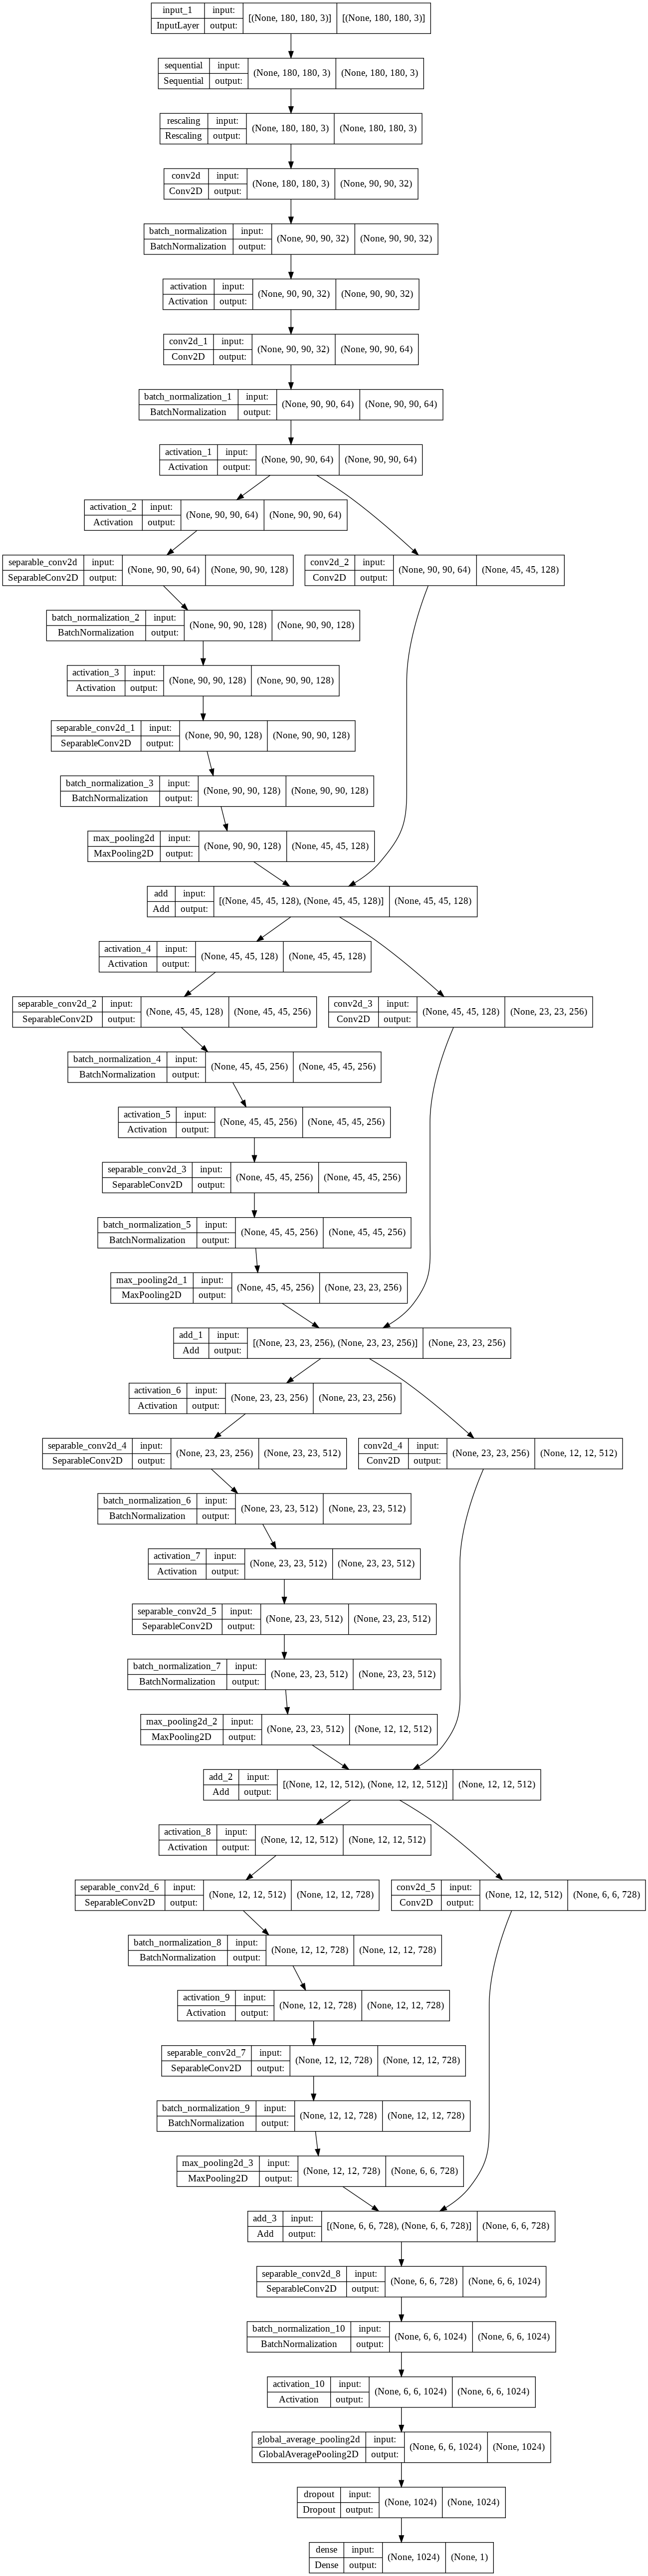

In [10]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [13]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(  
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/20
586/586 [==============================] - 154s 259ms/step - loss: 0.4883 - accuracy: 0.7675 - val_loss: 0.4762 - val_accuracy: 0.7768
Epoch 2/20
586/586 [==============================] - 151s 257ms/step - loss: 0.3838 - accuracy: 0.8291 - val_loss: 0.3822 - val_accuracy: 0.8270
Epoch 3/20
586/586 [==============================] - 151s 258ms/step - loss: 0.3096 - accuracy: 0.8668 - val_loss: 0.2732 - val_accuracy: 0.8851
Epoch 4/20
586/586 [==============================] - 151s 258ms/step - loss: 0.2737 - accuracy: 0.8855 - val_loss: 0.3573 - val_accuracy: 0.8368
Epoch 5/20
586/586 [==============================] - 154s 262ms/step - loss: 0.2305 - accuracy: 0.9065 - val_loss: 0.2215 - val_accuracy: 0.9073
Epoch 6/20
586/586 [==============================] - 154s 262ms/step - loss: 0.2071 - accuracy: 0.9153 - val_loss: 0.2146 - val_accuracy: 0.9131
Epoch 7/20
586/586 [==============================] - 154s 261ms/step - loss: 0.1924 - accuracy: 0.9200 - val_loss: 0.1778 -

NameError: ignored

In [14]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/6779.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 53.82 percent cat and 46.18 percent dog.
